# Preliminary analysis ECG simulated datasets

In [59]:
import os
import sys
os.chdir("/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/bin")
sys.path.append(os.getcwd()) 
import torch

from flower.task import Net, train
import glob
import torch
# import dataloader
from torch.utils.data import DataLoader
from lib.dataset_utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
from lib.physionet import PhysioNet, variable_time_collate_fn, get_data_min_max
from sklearn import model_selection
from torch.utils.data import DataLoader
from lib import utils
from lib.dataset_utils import store_dataset_physionet
import matplotlib.pyplot as plt
from lib.plot import plot_trajectories
from lib.plot_utils import read_loss_file, get_summary_lambdas, plot_client_loss
from matplotlib.lines import Line2D

path_prefix = "/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/data"
prefix = "physionet"
batch_size = 64
classif = False
noise_weight = 0.1
max_t_extrap = 5
n_total_tp = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
amp_start = 1.0
amp_end = 1.0 
freq_start =1.0
freq_end = freq_start
epochs = 5
batch_size = 3
sample_tp = 0.9
n_samples = 4
max_t_extrap = 50
lr_val = 0.01
cut_tp = None
extrap = None
rec_layers = 3
gen_layers = 3
units = 500
gru_units = 500
latents = 30
rec_dims = 40

from types import SimpleNamespace
args = SimpleNamespace()
args.sample_tp = 0
args.cut_tp = None
args.extrap = None

res_folder = "results_ecg_simulation_new"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Centralized training

In [60]:
####################################
#     Centralized training results
####################################

result_json_centralized = glob.glob(f"../{res_folder}/**/centralized_training/**/**/**/loss_per_epoch.csv", recursive=True)
result_json_centralized = list(set(result_json_centralized))
result_json_centralized

df_centralized = pd.DataFrame()
for file in result_json_centralized:
    df_centralized_temp = pd.read_csv(file)
    df_centralized_temp['run_id'] = file.split("/")[-3] + "_" + file.split("/")[-2]
    df_centralized_temp["dataset_name"] = file.split("/")[-5]
    df_centralized = pd.concat([df_centralized, df_centralized_temp])
df_centralized = df_centralized.reset_index(drop=True)
df_centralized["dataset_name"] = df_centralized["dataset_name"].str.replace("ecg_physionet_", "")
df_centralized

# get the min train and val loss for each run_id
df_centralized_min = df_centralized.groupby('dataset_name').agg({'train_loss': 'min', 'val_loss': 'min'}).reset_index()

# create a column called loss and another called type that takes eithe train or val based on whether the value comes from train_loss or val_loss
df_centralized['loss'] = df_centralized['train_loss']
df_centralized['type'] = 'train'
df_centralized_val = df_centralized.copy()
df_centralized_val['loss'] = df_centralized['val_loss']
df_centralized_val['type'] = 'val'
df_centralized = pd.concat([df_centralized, df_centralized_val])
df_centralized = df_centralized.reset_index(drop=True)
df_centralized["client"] = "centralized_training"

# order by dataset_name
df_centralized = df_centralized.sort_values(by=["dataset_name"]).reset_index(drop=True)


<Figure size 1000x300 with 0 Axes>

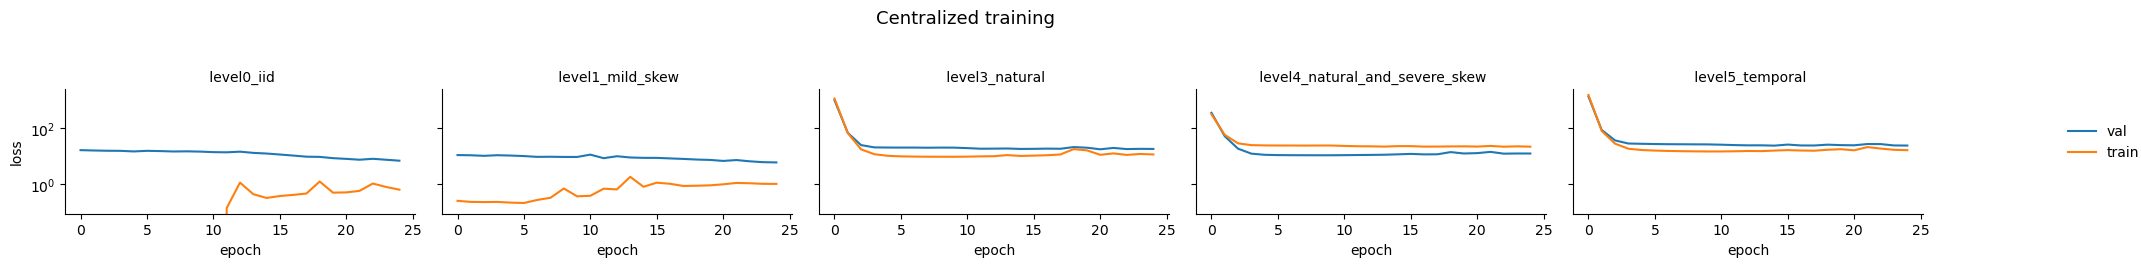

In [61]:
# fig size
plt.figure(figsize=(10, 3))


# Create FacetGrid
g = sns.FacetGrid(
    df_centralized,
    col="dataset_name",
    height=2.5,
    aspect=1.5,  # Width = height * aspect
    sharey=True
)

# Map the lineplot onto the grid
g.map_dataframe(
    sns.lineplot,
    x='epoch',
    y='loss',
    hue='type',
    markers=True,
    palette='tab10'
)

# Adjustments
g.set_axis_labels("epoch", "loss")
g.set_titles(" {col_name}")
#g.set(ylim=(0, None))

# add general title
g.fig.suptitle("Centralized training", fontsize=13, y=1.05)

# Move legend outside
g.add_legend(title ="")
g._legend.set_bbox_to_anchor((1.05, 0.5))
# legend 
g._legend.set_loc("center left")
# title
# y axis log
plt.yscale('log')


plt.tight_layout()
plt.show()

# Playing with the visualization of the results

In [62]:
# # Load dataset
# dataset_name = "ecg_physionet_level3_natural"
# c0 = torch.load(f"/Users/luisa/Desktop/nygc/data_test/{dataset_name}/client_0_test.pt", weights_only=False)
# #c1 = torch.load(f"/Users/luisa/Desktop/nygc/data_test/ecg_physionet_level0_iid/client_1_train.pt", weights_only=False)
# # attr_names = torch.load(f"/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/data/physionet_filtered/attr_names.pt", weights_only=False)
# # attr_names_filtered = attr_names
# # create list of string from 0 to 11
# attr_names_filtered = np.array([f"var_{i}" for i in range(12)])
# # load model weights 
# model = Net()
# w_cen = torch.load(f"/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/results_ecg_simulation_new/{dataset_name}/centralized_training/25_epochs/lr_0.001-batchsize_32_clipping_False_lrdecay_1.0/model.pth",  map_location=torch.device('cpu'), weights_only=True)
# # w_local = torch.load("/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/results_physionet_filtered/physionet_filtered/local_training/client_0/10_epochs/10_epochs/lr_0.001-batchsize_64_clipping_False_lrdecay_1.0/model.pth",  map_location=torch.device('cpu'), weights_only=True)
# model.load_state_dict(w_cen)
# # #model.load_state_dict(w_local)

In [63]:
# n_traj_to_show = 3
# filtered_dataset = c0[10:40]
# data_min, data_max = get_data_min_max(filtered_dataset)
# testloader = DataLoader(filtered_dataset, batch_size= batch_size, shuffle=False,
#     collate_fn= lambda batch: variable_time_collate_fn(batch, args, "cpu", data_type = "test",
#         data_min = data_min, data_max = data_max))

# testloader = utils.inf_generator(testloader)
# test_dict = utils.get_next_batch(testloader)

# # prepare dictionary in the format needed for prediction and plotting
# data =  test_dict["data_to_predict"]
# time_steps = test_dict["tp_to_predict"]
# mask = test_dict["mask_predicted_data"]

# observed_data =  test_dict["observed_data"]
# observed_time_steps = test_dict["observed_tp"]
# observed_mask = test_dict["observed_mask"]


# time_steps_to_predict = time_steps
# time_steps_to_predict = utils.linspace_vector(time_steps[0], time_steps[-1], 100).to(device)

# with torch.no_grad():

#     # Here use the model to obtain the predictions
#     reconstructions, info = model.get_reconstruction(time_steps_to_predict, 
#         observed_data, observed_time_steps, mask = observed_mask, n_traj_samples = 10)

#     # plot only 10 trajectories
#     data_for_plotting = observed_data[:n_traj_to_show]
#     mask_for_plotting = observed_mask[:n_traj_to_show]

#     data_full = data[:n_traj_to_show]

#     reconstructions_for_plotting = reconstructions.mean(dim=0)[:n_traj_to_show]
#     reconstr_std = reconstructions.std(dim=0)[:n_traj_to_show]

#     for dim_to_show in range(attr_names_filtered.shape[0]):
#         name = attr_names_filtered[dim_to_show]
#         ax_traj = []
#         fig, ax_traj = plt.subplots(1, n_traj_to_show)
#         fig.set_size_inches(12, 1.5)
#         max_y = max(
#             data_for_plotting[:,:,dim_to_show].cpu().numpy().max(),
#             reconstructions[:,:,dim_to_show].cpu().numpy().max())
#         min_y = min(
#             data_for_plotting[:,:,dim_to_show].cpu().numpy().min(),
#             reconstructions[:,:,dim_to_show].cpu().numpy().min())
        
#         cmap = plt.colormaps['Set1']
#         for traj_id in range(n_traj_to_show):

#             # Plot observations
#             plot_trajectories(ax_traj[traj_id], 
#                 data_full[traj_id].unsqueeze(0), observed_time_steps, 
#                 mask = mask_for_plotting[traj_id].unsqueeze(0),
#                 min_y = min_y, max_y = max_y, #title="True trajectories", 
#                 marker = 'o', linestyle='', dim_to_show = dim_to_show, markersize= 2, alpha =0.9,
#                 color = "grey")
#                     # Plot observations
#             plot_trajectories(ax_traj[traj_id], 
#                 data_for_plotting[traj_id].unsqueeze(0), observed_time_steps, 
#                 mask = mask_for_plotting[traj_id].unsqueeze(0),
#                 min_y = min_y, max_y = max_y, #title="True trajectories", 
#                 marker = 'o', linestyle='', dim_to_show = dim_to_show, add_to_plot= True, markersize= 2.5, alpha =0.5,
#                 color = "black")
            
#             # Plot reconstructions
#             plot_trajectories(ax_traj[traj_id],
#                 reconstructions_for_plotting[traj_id].unsqueeze(0), time_steps_to_predict, 
#                 min_y = min_y, max_y = max_y, title="{}  -  sample {}".format(name, traj_id), dim_to_show = dim_to_show,
#                 add_to_plot = True, marker = '', color =  "darkorange", linewidth = 1.3, linestyle='-', alpha = 0.9)
#             ax_traj[traj_id].set_ylim(min_y - 0.3, max_y+ 0.3)
#     # print(min_y)
    
# plt.show()

# Local training (within each client)

In [64]:
####################################
#     Local training results
####################################

result_json_local = glob.glob(f"../{res_folder}/**/local_training/**/loss_per_epoch.csv", recursive=True)
result_json_local = list(set(result_json_local))
result_json_local

# plot loss per epoch
df_local = pd.DataFrame()
for file in result_json_local:
    df_local_temp = pd.read_csv(file)
    df_local_temp["client"] = file.split("/")[-5]
    df_local_temp["run_id"] = file.split("/")[-3] + "_" + file.split("/")[-2]
    df_local_temp["dataset_name"] = file.split("/")[-7]
    df_local = pd.concat([df_local, df_local_temp])
df_local["dataset_name"] = df_local["dataset_name"].str.replace("ecg_physionet_", "")

df_local_train = df_local.copy()
df_local_val = df_local.copy()
df_local_train['loss'] = df_local_train['train_loss']
df_local_train['type'] = 'train'
# rename columns
df_local_val['loss'] = df_local_val['val_loss']
df_local_val['type'] = 'val'
df_local = pd.concat([df_local_train, df_local_val])

df_local = df_local.drop(columns=['train_loss', 'val_loss'])
df_local = df_local.reset_index(drop=True)
df_local = df_local.sort_values(by=["dataset_name"]).reset_index(drop=True)


In [65]:
# identify minimum loss per client and run_id
df_local_min = df_local.groupby(["client", "dataset_name", "run_id", "type"]).min().reset_index()
df_local_min = df_local_min[["client", "dataset_name", "loss", "type"]]
df_local_min = df_local_min.sort_values(by=["dataset_name"]).reset_index(drop=True)
df_local_min["level"] = df_local_min["dataset_name"].str.split("_").str[0]
df_local_min

,client,dataset_name,loss,type,level
0,client_0,level0_iid,1.678683,train,level0
1,client_0,level0_iid,10.585600,val,level0
2,client_1,level0_iid,12.307047,val,level0
3,client_1,level0_iid,2.059075,train,level0
4,client_0,level1_mild_skew,6.118062,train,level1
5,client_0,level1_mild_skew,17.168805,val,level1
6,client_1,level1_mild_skew,9.564861,val,level1
7,client_1,level1_mild_skew,3.293781,train,level1
8,client_0,level2_severe_skew,5.540611,train,level2
9,client_0,level2_severe_skew,9.787713,val,level2


<Figure size 1000x300 with 0 Axes>

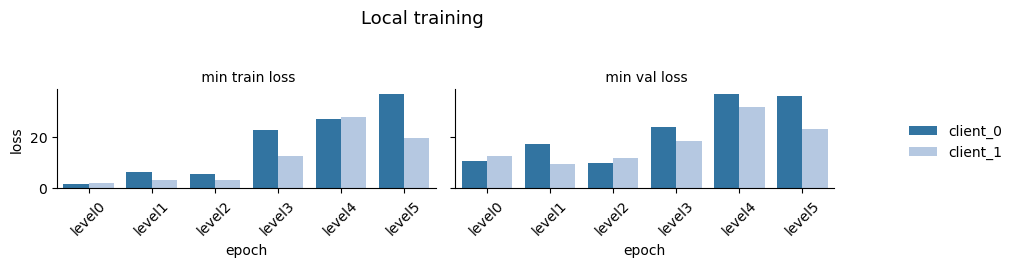

In [66]:
# plot each dataset in x axis, y is loss and hue is client 
plt.figure(figsize=(10, 3))
# Create FacetGrid
g = sns.FacetGrid(
    df_local_min,
    col="type",
    height=2.5,
    aspect=1.5,  # Width = height * aspect
    sharey=True
)
# Map the barplot onto the grid
g.map_dataframe(
    sns.barplot,
    x='level',
    y='loss',
    hue='client',
    palette='tab20'
)
# Adjustments
g.set_axis_labels("epoch", "loss")
g.set_titles(" min {col_name} loss")
#g.set(ylim=(0, None))

# add general title
g.fig.suptitle("Local training", fontsize=13, y=1.05)
# Move legend outside
g.add_legend(title ="")
g._legend.set_bbox_to_anchor((1.05, 0.5))
# make x axis 45 degrees
g.set_xticklabels(rotation=45)
# legend
g._legend.set_loc("center left")
# title
# y axis log
plt.tight_layout()
plt.show()

In [67]:
# average loss across clients for each dataset
df_local_avg = df_local_min[["level", "type", "loss"]].groupby(["level", "type"]).mean().reset_index()
df_local_avg["dummy"] = 0

<Figure size 1000x300 with 0 Axes>

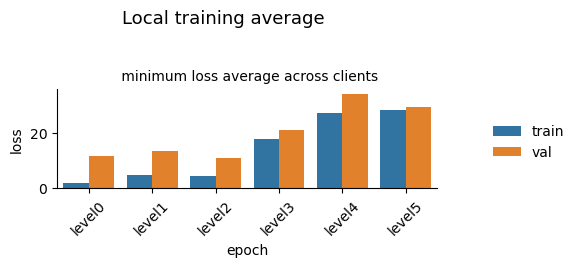

In [68]:
# plot each dataset in x axis, y is loss and hue is client 
plt.figure(figsize=(10, 3))
# Create FacetGrid
g = sns.FacetGrid(
    df_local_avg,
    col="dummy",
    height=2.5,
    aspect=1.5,  # Width = height * aspect
    sharey=True
)
# Map the barplot onto the grid
g.map_dataframe(
    sns.barplot,
    x='level',
    y='loss',
    hue='type',
    palette='tab10'
)
# Adjustments
g.set_axis_labels("epoch", "loss")
g.set_titles(" minimum loss average across clients")
#g.set(ylim=(0, None))

# add general title
g.fig.suptitle("Local training average", fontsize=13, y=1.05)
# Move legend outside
g.add_legend(title ="")
g._legend.set_bbox_to_anchor((1.05, 0.5))
# make x axis 45 degrees
g.set_xticklabels(rotation=45)
# legend
g._legend.set_loc("center left")
# title
# y axis log
plt.tight_layout()
plt.show()

In [69]:
df_local

,epoch,train_mse,val_mse,nodesolves,client,run_id,dataset_name,loss,type
0,0,0.001347,0.001689,63480,client_0,25_epochs_lr_0.001-batchsize_32_clipping_False...,level0_iid,1.949657,train
1,21,0.001390,0.001698,64208,client_1,25_epochs_lr_0.001-batchsize_32_clipping_False...,level0_iid,3.244676,train
2,22,0.001383,0.001698,64208,client_1,25_epochs_lr_0.001-batchsize_32_clipping_False...,level0_iid,3.250208,train
3,23,0.001531,0.001891,64208,client_1,25_epochs_lr_0.001-batchsize_32_clipping_False...,level0_iid,3.927902,train
4,23,0.001531,0.001891,64208,client_1,25_epochs_lr_0.001-batchsize_32_clipping_False...,level0_iid,12.916858,val
...,...,...,...,...,...,...,...,...,...
595,21,0.004984,0.003930,4550,client_1,25_epochs_lr_0.001-batchsize_32_clipping_False...,level5_temporal,23.483418,val
596,22,0.004928,0.003830,4550,client_1,25_epochs_lr_0.001-batchsize_32_clipping_False...,level5_temporal,23.361725,val
597,23,0.004986,0.003873,4550,client_1,25_epochs_lr_0.001-batchsize_32_clipping_False...,level5_temporal,23.478208,val
598,13,0.004909,0.003843,4550,client_1,25_epochs_lr_0.001-batchsize_32_clipping_False...,level5_temporal,23.739710,val


<Figure size 1000x300 with 0 Axes>

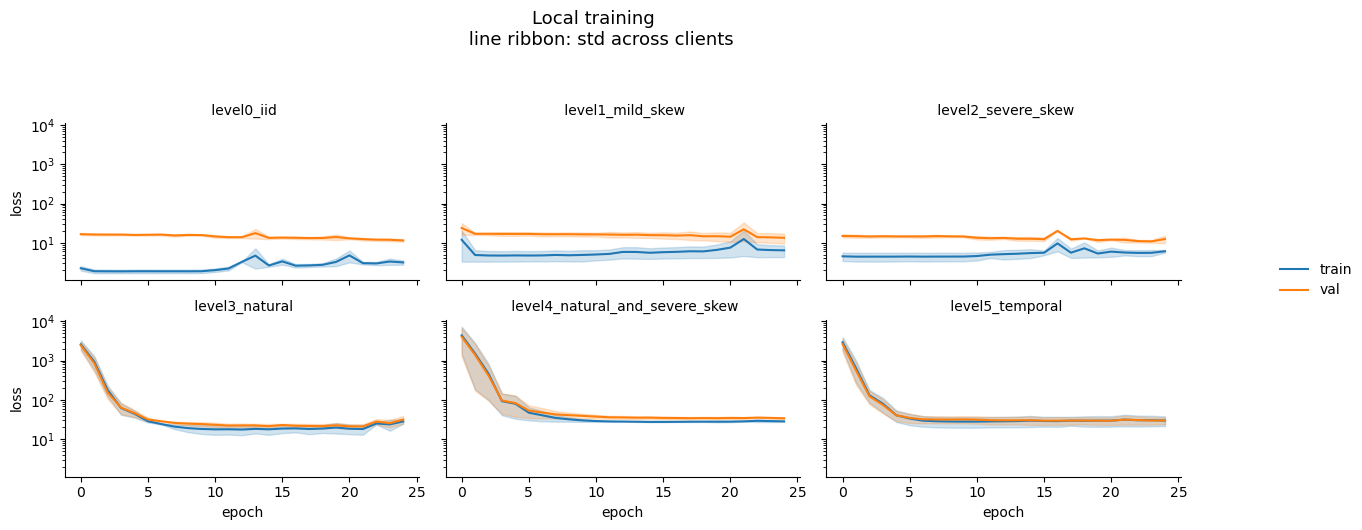

In [70]:
# fig size
plt.figure(figsize=(10, 3))


# Create FacetGrid
g = sns.FacetGrid(
    df_local,
    col="dataset_name",
    height=2.5,
    aspect=1.5,  # Width = height * aspect
    sharey=True,
    col_wrap=3  # Adjust this to control the number of columns in the grid
)

# Map the lineplot onto the grid
g.map_dataframe(
    sns.lineplot,
    x='epoch',
    y='loss',
    hue='type',
    markers=True,
    palette='tab10'
)

# Adjustments
g.set_axis_labels("epoch", "loss")
g.set_titles(" {col_name}")
#g.set(ylim=(0, None))

# add general title
g.fig.suptitle("Local training  \n line ribbon: std across clients", fontsize=13, y=1.05)

# Move legend outside
g.add_legend(title ="")
g._legend.set_bbox_to_anchor((1.05, 0.5))
# legend 
g._legend.set_loc("center left")
# title
# y axis log
plt.yscale('log')


plt.tight_layout()
plt.show()

# Federated training

In [71]:
####################################
#     Federated training results
####################################

result_json = glob.glob(f"../{res_folder}/**/federated_training/**/**/**/results.json", recursive=True)
result_json = list(set(result_json))
result_json

df_centralized_evaluate = pd.DataFrame()
df_federated_evaluate = pd.DataFrame()
df_aggregation = pd.DataFrame()
for file in result_json:
    df_centralized_evaluate_temp, df_federated_evaluate_temp, df_aggregation_temp = read_loss_file(file)
    df_centralized_evaluate = pd.concat([df_centralized_evaluate, df_centralized_evaluate_temp])
    df_federated_evaluate = pd.concat([df_federated_evaluate, df_federated_evaluate_temp])
    df_aggregation_temp["dataset_name"] = file.split("/")[-7]
    df_aggregation = pd.concat([df_aggregation, df_aggregation_temp])
df = pd.concat([df_centralized_evaluate, df_federated_evaluate])
# remove string ecg_physionet from dataset_name in df
df["dataset_name"] = df["dataset_name"].str.replace("ecg_physionet_", "")
# sort by dataset_name
df = df.sort_values(by=["dataset_name"]).reset_index(drop=True)
df_aggregation["dataset_name"] = df_aggregation["dataset_name"].str.replace("ecg_physionet_", "")
df_summary_lambdas = get_summary_lambdas(df_aggregation)
df_federated = df


/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/bin/lib/plot_utils.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_summary_aggregation["client_1"] = df_summary_aggregation['clients'].apply(lambda x: x[1] if isinstance(x, list) and len(x) > 1 else None)
/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/bin/lib/plot_utils.py:258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/bin/lib/plot_utils.py:261: SettingWithCopyWarning: 
A value is trying to b

<Figure size 1000x300 with 0 Axes>

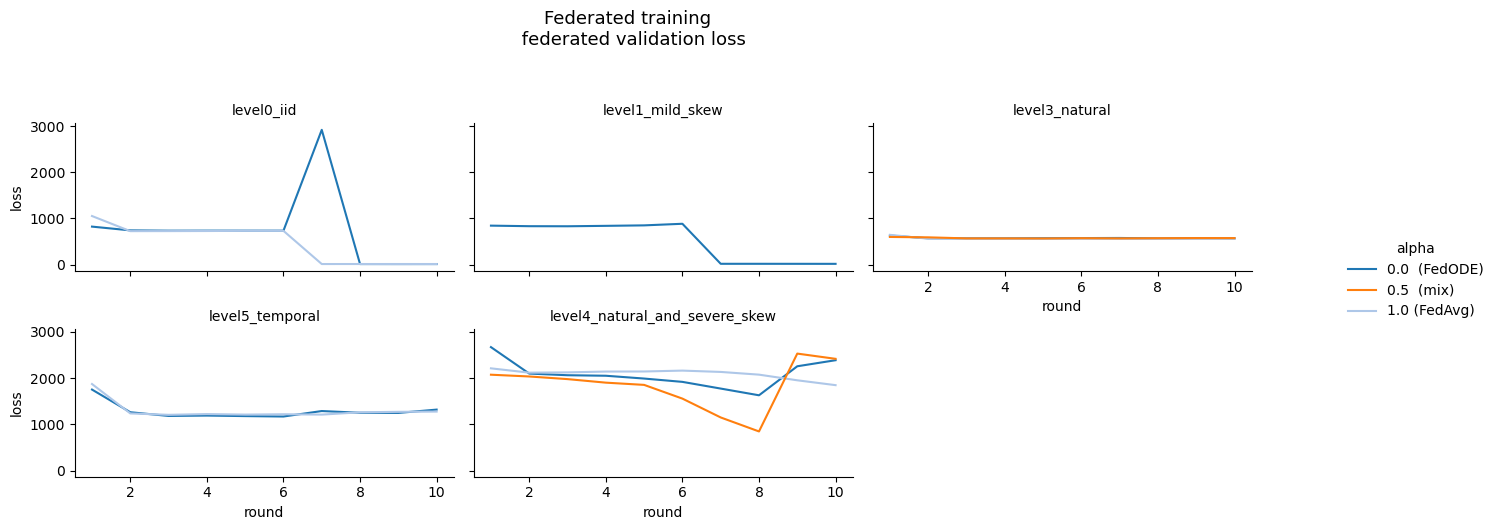

In [72]:
loss_df = df[df['type'].isin(["centralized", "federated"])]
loss_df = loss_df[loss_df["type"] == "federated"]

# sort dataset_name by given order
dataset_order = ['level0_iid', 'level1_mild_skew', 'level3_natural',"level5_temporal",
       'level4_natural_and_severe_skew']
loss_df['dataset_name'] = pd.Categorical(loss_df['dataset_name'], categories=dataset_order, ordered=True)

# add to leged is alpha is 0.0 fedODE 
loss_df['alpha'] = loss_df['alpha'].astype(str)
loss_df['alpha'] = loss_df['alpha'].replace({'0.0': '0.0  (FedODE)', '0.5': '0.5  (mix)', '1.0': '1.0 (FedAvg)'})

# fig size
plt.figure(figsize=(10, 3))
# Create FacetGrid
g = sns.FacetGrid(
    loss_df,
    col="dataset_name",
    height=2.5,
    aspect=1.5,  # Width = height * aspect
    sharey=True,
    col_wrap=3  # Adjust this to control the number of columns in the grid
)

# Map the lineplot onto the grid
g.map_dataframe(
    sns.lineplot,
    x='round',
    y='loss',
    hue='alpha',
    markers=True,
    palette='tab20'
)

# Adjustments
g.set_axis_labels("round", "loss")
g.set_titles("alpha {col_name}")
# add row_titles
g.set_titles(col_template="{col_name}", row_template="{row_name}")
#g.set(ylim=(0, None))
# add general title
g.fig.suptitle("Federated training \n federated validation loss", fontsize=13, y=1.05)
# Move legend outside
g.add_legend(title ="alpha")
g._legend.set_bbox_to_anchor((1.05, 0.5))
# legend 
g._legend.set_loc("center left")
# title
# plot the legend of plot

plt.tight_layout()
plt.show()

# Training loss within each client

In [73]:
result_json_client = glob.glob(f"../{res_folder}/**/federated_training/**/**/**/results_0.json", recursive=True)
result_json_client = list(set(result_json_client))

Loading meta data from ../results_ecg_simulation_new/ecg_physionet_level4_natural_and_severe_skew/federated_training/FedODE/10_rounds/rep_1-alpha_0.0-lr_0.001-batchsize_32_clipping_False_lrdecay_1.0_localepochs_10_decayonset_15_alpha_0.0/federated_outputs/meta.csv


/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/bin/lib/plot_utils.py:346: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.


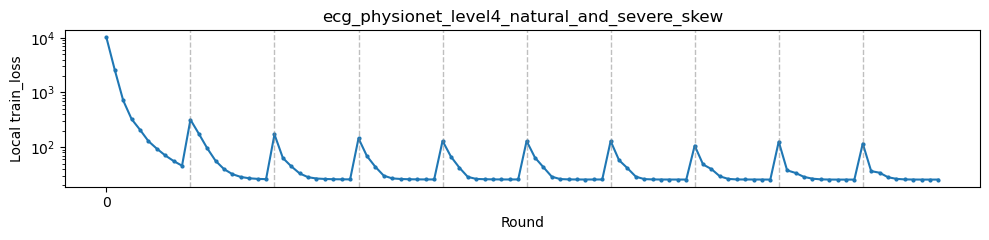

Loading meta data from ../results_ecg_simulation_new/ecg_physionet_level0_iid/federated_training/FedODE/10_rounds/rep_1-alpha_0.0-lr_0.001-batchsize_32_clipping_False_lrdecay_1.0_localepochs_10_decayonset_15_alpha_0.0/federated_outputs/meta.csv


/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/bin/lib/plot_utils.py:346: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.


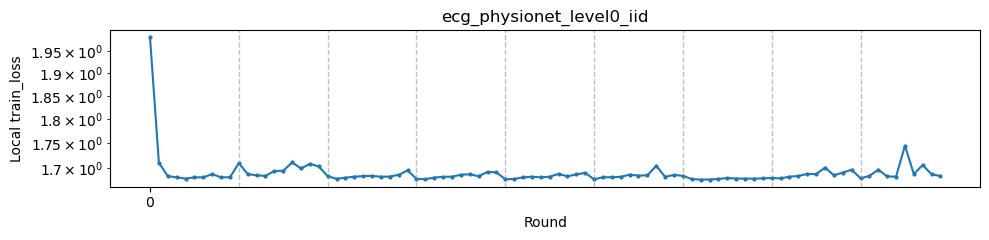

Loading meta data from ../results_ecg_simulation_new/ecg_physionet_level3_natural/federated_training/FedODE/10_rounds/rep_1-alpha_0.0-lr_0.001-batchsize_32_clipping_False_lrdecay_1.0_localepochs_10_decayonset_15_alpha_0.0/federated_outputs/meta.csv


/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/bin/lib/plot_utils.py:346: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.


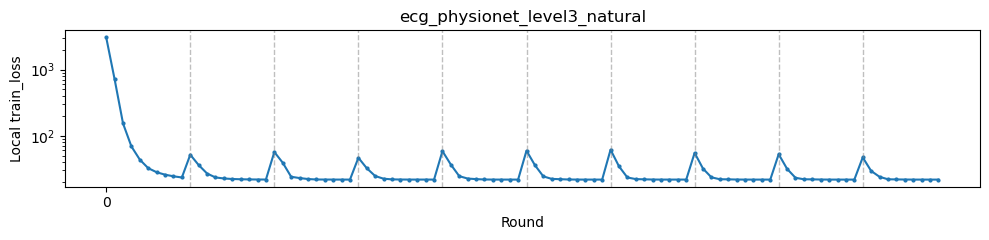

In [74]:
client_file = result_json_client[2]
for file in result_json_client:
    # if file name containes "alpha_0.5" 
    if "alpha_0.0" in file:
        plot_client_loss(file, type_loss = "train_loss", nrounds = 10, log = True)


In [75]:
df_summary_lambdas

,round,dataset_name,lambda,steps,alpha,client
0,1,level4_natural_and_severe_skew,0.500411,1826.0,0.5,1
1,2,level4_natural_and_severe_skew,0.501230,1838.0,0.5,0
2,3,level4_natural_and_severe_skew,0.500000,1820.0,0.5,1
3,4,level4_natural_and_severe_skew,0.500821,1832.0,0.5,0
4,5,level4_natural_and_severe_skew,0.499179,1820.0,0.5,1
...,...,...,...,...,...,...
191,6,level4_natural_and_severe_skew,0.500000,1820.0,1.0,1
192,7,level4_natural_and_severe_skew,0.500000,1820.0,1.0,0
193,8,level4_natural_and_severe_skew,0.500000,1826.0,1.0,1
194,9,level4_natural_and_severe_skew,0.500000,1838.0,1.0,1


# Investigate the number of ODE steps

In [76]:
df_summary_lambdas["level"] = df_summary_lambdas["dataset_name"].str.split("_").str[0].replace({"level0": "0", "level1": "1", "level2": "2", "level3": "3", "level4": "4", "level5": "5"})
df_summary_lambdas_0 = df_summary_lambdas[df_summary_lambdas["level"] == "0"]
df_summary_lambdas_1 = df_summary_lambdas[df_summary_lambdas["level"] == "1"]
df_summary_lambdas_2 = df_summary_lambdas[df_summary_lambdas["level"] == "2"]
df_summary_lambdas_3 = df_summary_lambdas[df_summary_lambdas["level"] == "3"]
df_summary_lambdas_4 = df_summary_lambdas[df_summary_lambdas["level"] == "4"]
df_summary_lambdas_5 = df_summary_lambdas[df_summary_lambdas["level"] == "5"]

<Figure size 1000x300 with 0 Axes>

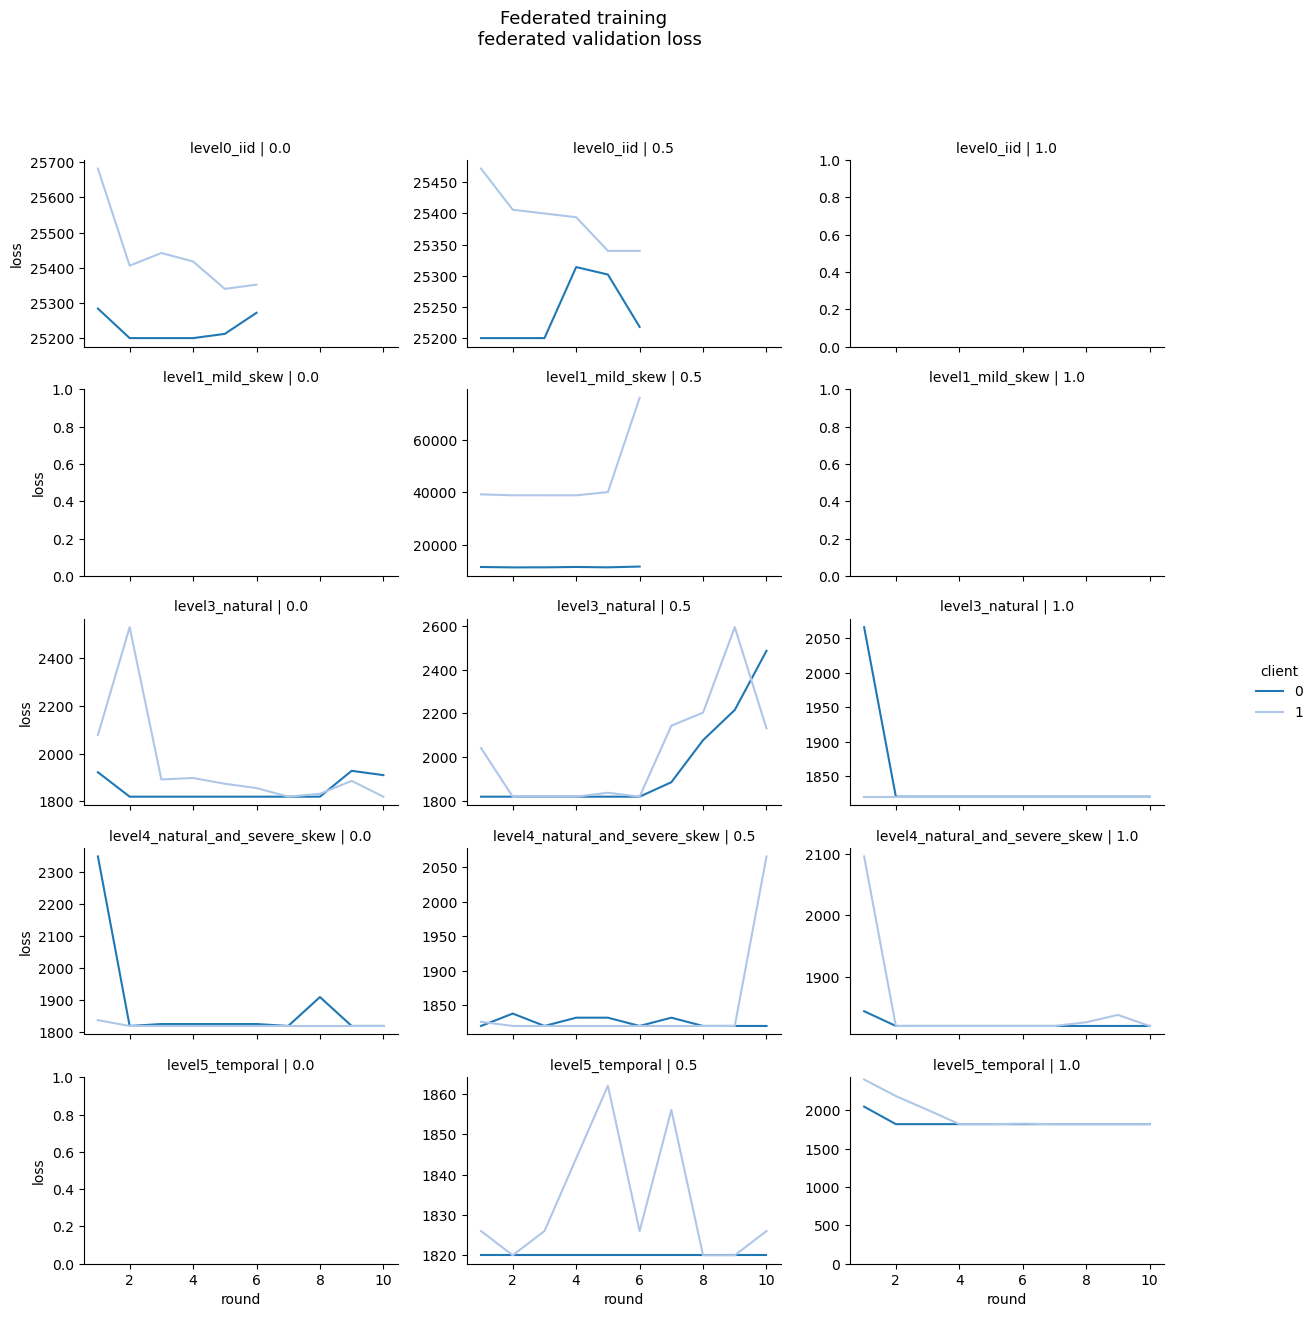

In [77]:
# sort dataset_name by alphabetical order
df_summary_lambdas = df_summary_lambdas.sort_values(by="dataset_name").reset_index(drop=True)

# fig size
plt.figure(figsize=(10, 3))
# Create FacetGrid
g = sns.FacetGrid(
    df_summary_lambdas,
    col="alpha",
    row="dataset_name",
    height=2.5,
    aspect=1.5,  # Width = height * aspect
    sharey=False) # Adjust this to control the number of columns in the grid)

# Map the lineplot onto the grid
g.map_dataframe(
    sns.lineplot,
    x='round',
    y='steps',
    hue='client',
    markers=True,
    palette='tab20'  # Use a colorblind-friendly palette
)

# Adjustments
g.set_axis_labels("round", "loss")
g.set_titles("client {col_name}")
# add row_titles
g.set_titles(col_template="{col_name}", row_template="{row_name}")
#g.set(ylim=(0, None))
# add general title
g.fig.suptitle("Federated training \n federated validation loss", fontsize=13, y=1.05)
# Move legend outside
g.add_legend(title ="client")
g._legend.set_bbox_to_anchor((1.05, 0.5))
# legend 
g._legend.set_loc("center left")
# title
# plot the legend of plot
# y starts at 0
plt.ylim(0, None)
# y log scale
plt.tight_layout()
plt.show()

In [78]:
#df_centralized_min and df_local_min group by id 
df_centralized_min = df_centralized_min.rename(columns={"train_loss": "train_loss_min", "val_loss": "val_loss_min"})
# remove __ from dataset_name
df_centralized_min["level"] = df_centralized_min["dataset_name"].str.split("_").str[0]
# remove __ from dataset_name
# separate validation and training loss
df_cen_train = df_centralized_min[["level", "train_loss_min"]].rename(columns={"train_loss_min": "loss"})
df_cen_val = df_centralized_min[["level", "val_loss_min"]].rename(columns={"val_loss_min": "loss"})
df_cen_train["type"] = "train"
df_cen_val["type"] = "val"
df_centralized_min = pd.concat([df_cen_train, df_cen_val])
df_centralized_min["training_type"] = "centralized"
df_local_avg["training_type"] = "local"
# remove dummy column
df_local_avg = df_local_avg.drop(columns=["dummy"])
df_centralized_min = df_centralized_min.drop(columns=["training_type"])
df_local_avg = df_local_avg.drop(columns=["training_type"])
df_federated["level"] = df_federated["dataset_name"].str.split("_").str[0]
df_federated_min = df_federated[["level", "round", "loss", "type", "alpha"]] 
df_federated_min = df_federated_min[df_federated_min["type"] == "federated"]
# now keep the minimum loss for each dataset_name and alpha
df_federated_min = df_federated_min.groupby(["level", "alpha", "type"]).min().reset_index()
df_federated_min = df_federated_min.rename(columns={"loss": "loss_min"})
df_federated_min["training_type"] = "federated"
df_federated_min["type"] = "val"

# Summarize table with best loss 

In [94]:
# merge df_centralized_min and df_local_avg by level, type
# drop training type column from df_centralized_min and df_local_avg

df_combined = pd.merge(df_centralized_min, df_local_avg, on=["level", "type"], how="outer", suffixes=('_cen', '_local'))
df_combined = pd.merge(df_combined, df_federated_min, on=["level", "type"], how="outer")
df_combined
# reorder columns level, type, loss_cen, loss_local
df_combined = df_combined[["level", "type", "alpha", "loss_cen", "loss_local", "loss_min"]]
df_combined = df_combined.rename(columns={"loss_min": "loss_fed"})
# sort by level, type, alpha
df_combined = df_combined.sort_values(by=["level", "type", "alpha"]).reset_index(drop=True)
# rename columns

df_combined_train = df_combined[df_combined["type"] == "train"]
df_combined_val = df_combined[df_combined["type"] == "val"]
# order by level
df_combined_train = df_combined_train.sort_values(by=["level", "alpha"]).reset_index(drop=True)
# rename loss_min to skasdlsajjdf_combined_val
df_combined_val_0 = df_combined_val[df_combined_val["alpha"] == 0.0]
df_combined_val_1 = df_combined_val[df_combined_val["alpha"] == 1.0]

 # order by level


In [115]:
df_combined_val

df_combined_cen = df_combined_val.copy()
df_combined_cen["loss"] = df_combined_cen["loss_cen"]
df_combined_cen["loss_type"] = "centralized"
df_combined_cen.drop(columns=["loss_cen", "loss_local", "loss_fed"], inplace=True)

df_combined_local = df_combined_val.copy()
df_combined_local["loss"] = df_combined_local["loss_local"]
df_combined_local["loss_type"] = "local"
df_combined_local.drop(columns=["loss_cen", "loss_local", "loss_fed"], inplace=True)

df_combined_fed = df_combined_val.copy()
df_combined_fed["loss"] = df_combined_fed["loss_fed"]
df_combined_fed["loss_type"] = "federated"
df_combined_fed.drop(columns=["loss_cen", "loss_local", "loss_fed"], inplace=True)
# concatenate all dataframes
df_combined_all = pd.concat([df_combined_cen, df_combined_local, df_combined_fed])
# sort by level, loss_type


categories = ['centralized', 'local', 'federated']
df_combined_all['loss_type'] = pd.Categorical(df_combined_all['loss_type'], categories=categories, ordered=True)
df_combined_all["level"] = df_combined_all["level"].str.replace("level", "").astype(int)
# sort by level, loss_type
df_combined_all = df_combined_all.sort_values(by=["level"]).reset_index(drop=True)


In [116]:
df_combined_all

,level,type,alpha,loss,loss_type
0,0,val,0.0,6.930001,centralized
1,0,val,0.5,6.930001,centralized
2,0,val,0.5,13.667106,federated
3,0,val,0.0,12.764309,federated
4,0,val,0.0,11.446324,local
5,0,val,0.5,11.446324,local
6,1,val,0.5,6.010493,centralized
7,1,val,0.5,17.824161,federated
8,1,val,0.5,13.366833,local
9,2,val,NaN,NaN,centralized


<Figure size 1000x500 with 0 Axes>

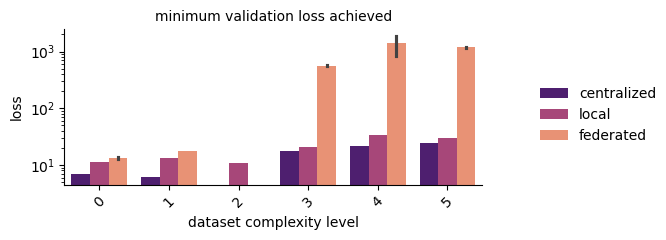

In [126]:


# plot barplot 
plt.figure(figsize=(10, 5))
# Create FacetGrid
g = sns.FacetGrid(
    df_combined_all,
    col="type",
    height=2.5,
    aspect=1.5,  # Width = height * aspect
    sharey=True
) 
# Map the barplot onto the grid
g.map_dataframe(
    sns.barplot,
    x='level',
    y='loss',
    hue='loss_type',
    palette='magma'
)
# Adjustments
g.set_axis_labels("dataset complexity level", "loss")
g.set_titles("minimum validation loss achieved")
#g.set(ylim=(0, None))   
# add general title
# Move legend outside
g.add_legend(title ="")
g._legend.set_bbox_to_anchor((1.05, 0.5))
# legend 
g._legend.set_loc("center left")
# title
# make x axis 45 degrees
g.set_xticklabels(rotation=45)
# y axis log
plt.yscale('log')
plt.tight_layout()
plt.show()

# Plot latent dimension

Getting data min and max devices:  cpu


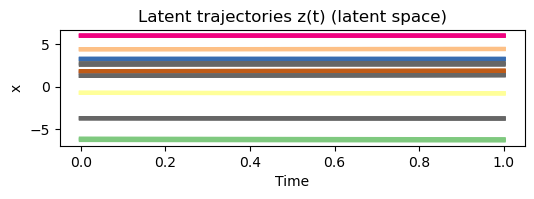

In [80]:
n_traj_to_show = 3
filtered_dataset = c0[10:40]
data_min, data_max = get_data_min_max(filtered_dataset)
testloader = DataLoader(filtered_dataset, batch_size= batch_size, shuffle=False,
    collate_fn= lambda batch: variable_time_collate_fn(batch, args, "cpu", data_type = "test",
        data_min = data_min, data_max = data_max))

testloader = utils.inf_generator(testloader)
test_dict = utils.get_next_batch(testloader)

# prepare dictionary in the format needed for prediction and plotting
data =  test_dict["data_to_predict"]
time_steps = test_dict["tp_to_predict"]
mask = test_dict["mask_predicted_data"]

observed_data =  test_dict["observed_data"]
observed_time_steps = test_dict["observed_tp"]
observed_mask = test_dict["observed_mask"]


time_steps_to_predict = time_steps
time_steps_to_predict = utils.linspace_vector(time_steps[0], time_steps[-1], 100).to(device)

with torch.no_grad():

    # Here use the model to obtain the predictions
    reconstructions, info = model.get_reconstruction(time_steps_to_predict, 
        observed_data, observed_time_steps, mask = observed_mask, n_traj_samples = 10)

    # plot only 10 trajectories
    data_for_plotting = observed_data[:n_traj_to_show]
    mask_for_plotting = observed_mask[:n_traj_to_show]

    data_full = data[:n_traj_to_show]

    reconstructions_for_plotting = reconstructions.mean(dim=0)[:n_traj_to_show]
    reconstr_std = reconstructions.std(dim=0)[:n_traj_to_show]

    # for dim_to_show in range(attr_names_filtered.shape[0]):
    #     name = attr_names_filtered[dim_to_show]
    ax_traj = []
    fig, ax_traj = plt.subplots(1, 1)
    fig.set_size_inches(6, 1.5)
    max_y = max(
        data_for_plotting[:,:,dim_to_show].cpu().numpy().max(),
        reconstructions[:,:,dim_to_show].cpu().numpy().max())
    min_y = min(
        data_for_plotting[:,:,dim_to_show].cpu().numpy().min(),
        reconstructions[:,:,dim_to_show].cpu().numpy().min())
    
    cmap = plt.colormaps['Set1']

    latent_traj = info["latent_traj"][0,:n_traj_to_show]
    # shape before permute: [1, n_tp, n_latent_dims]

    cmap = plt.colormaps['Accent']
    n_latent_dims = latent_traj.size(-1)

    custom_labels = {}
    for i in range(n_latent_dims):
        col = cmap(i)
        plot_trajectories(ax_traj, latent_traj, time_steps_to_predict, 
            title="Latent trajectories z(t) (latent space)", dim_to_show = i, color = col, 
            marker = '', add_to_plot = True,
            linewidth = 3)
            #custom_labels['dim ' + str(i)] = Line2D([0], [0], color=col)

        #ax_traj.set_ylabel("z")
        #ax_traj.set_title("Latent trajectories z(t) (latent space)", pad = 20)
        #ax_traj.legend(custom_labels.values(), custom_labels.keys(), loc = 'lower left')
plt.show()